## Mini-batch model for hpc run with input edge weights in csv file

Comments:

By using the read weighted edge list from a csv file, it saves much space on self.graph

This will for specific batch number and hop-layer number

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import copy
import csv
import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import shutil

from utils import *


### Test and compare different models

In [7]:
def store_data_multi_tests(f1_data, data_name, graph_model, img_path, comments):
    run_id = sorted(f1_data.keys())
    run_data = {'run_id': run_id}
    
    run_data.update({model_name : [f1_data[key][idx] for key in run_id] for idx, model_name in enumerate(graph_model)})
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, xlabel, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')
    
    

### Tune hyperparameters

In [8]:
def summarize_tuning_res(image_path, mini_batch_folder, tune_param_name, tune_val_list, trainer_list):
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    res = []
    for trainer_id in trainer_list:
        ref = {}
        for tune_val in tune_val_list:
            test_res_folder = image_path + 'test_res/tune_' + tune_param_name + '_' + str(tune_val) + '/'
            test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
            with open(test_res_file, "rb") as fp:
                ref[tune_val] = pickle.load(fp)
        res.append(ref)
    
    for i, ref in enumerate(res):
        validation_accuracy[i] = {tune_val : res_lst[0] for tune_val, res_lst in ref.items()}
        validation_f1[i] = {tune_val : res_lst[1] for tune_val, res_lst in ref.items()}
        time_total_train[i] = {tune_val : res_lst[2] for tune_val, res_lst in ref.items()}
        time_data_load[i] = {tune_val : res_lst[3] for tune_val, res_lst in ref.items()}
        
    return validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tuning(tune_params, target, data_name, img_path, comments):
    """
        tune_params: is the tuning parameter list
        target: is the result, here should be F1-score, accuraycy, load time, train time
    """
    run_ids = sorted(target.keys())   # key is the run_id
    run_data = {'run_id': run_ids}
    # the key can be converted to string or not: i.e. str(tune_val)
    # here we keep it as integer such that we want it to follow order
    tmp = {tune_val : [target[run_id][tune_val] for run_id in run_ids] for tune_val in tune_params}  # the value is list
    run_data.update(tmp)
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Seperate steps for parameter tuning

In [9]:
def step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_list, \
                                    train_batch_num, hop_layer_num, net_layer_num, trainer_list): 
    
    print('Start running training for partition num: ' + str(train_batch_num) + ' hop layer ' + str(hop_layer_num))
    # set the batch for validation and train
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '_hop_layer_num_' + str(hop_layer_num) + '/'
    img_path += 'tuning_parameters/'  # further subfolder for different task

    # start to summarize the results into images for output

    validation_accuracy, validation_f1, time_total_train, time_data_load = summarize_tuning_res(img_path, intermediate_data_path, tune_param_name, tune_val_list, trainer_list)
    
    generate_tuning_raw_data_table(validation_accuracy, img_path, 'validation_acc.csv', tune_param_name)
    validation_accuracy_file = store_data_multi_tuning(tune_val_list, validation_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(train_batch_num) + '_hops_' + str(hop_layer_num))
    draw_data_multi_tests(validation_accuracy_file, data_name, 'vali_cluster_num_' + str(train_batch_num) + '_hop_' + str(hop_layer_num), 'epochs_per_batch', 'Accuracy')
    
    generate_tuning_raw_data_table(validation_f1, img_path, 'validation_f1.csv', tune_param_name)
    validation_f1_file = store_data_multi_tuning(tune_val_list, validation_f1, data_name, img_path, 'validation_cluster_num_' + str(train_batch_num) + '_hops_' + str(hop_layer_num))
    draw_data_multi_tests(validation_f1_file, data_name, 'vali_cluster_num_' + str(train_batch_num) + '_hop_' + str(hop_layer_num), 'epochs_per_batch', 'F1 score')
    
    generate_tuning_raw_data_table(time_total_train, img_path, 'time_train_total.csv', tune_param_name)
    time_train_file = store_data_multi_tuning(tune_val_list, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(train_batch_num) + '_hops_' + str(hop_layer_num))
    draw_data_multi_tests(time_train_file, data_name, 'train_time_cluster_num_' + str(train_batch_num) + '_hop_' + str(hop_layer_num), 'epochs_per_batch', 'Train Time (ms)')

    generate_tuning_raw_data_table(time_data_load, img_path, 'time_load_data.csv', tune_param_name)
    time_load_file = store_data_multi_tuning(tune_val_list, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(train_batch_num) + '_hops_' + str(hop_layer_num))
    draw_data_multi_tests(time_load_file, data_name, 'load_time_cluster_num_' + str(train_batch_num) + '_hop_' + str(hop_layer_num), 'epochs_per_batch', 'Load Time (ms)')



### Use data from pytorch geometric datasets

In [10]:
data_name = 'Reddit'
test_folder_name = 'train_10%_full_neigh/'
image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './'
train_batch_num = 64
GCN_layer = [32]
net_layer_num = len(GCN_layer) + 1
# for non-optimization: hop_layer_num == net_layer_num
hop_layer_num = net_layer_num - 1
# to tune the parameters:
tune_param_name = 'batch_epoch_num'
# tune_val_list = [5]
tune_val_list = [400, 200, 100, 50, 20, 10, 5]
trainer_list = list(range(7))

Start running training for partition num: 64 hop layer 1


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

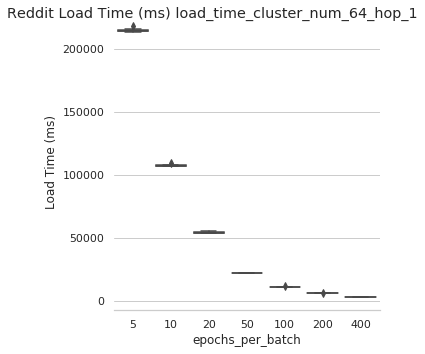

In [11]:
step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_list, \
                                train_batch_num, hop_layer_num, net_layer_num, trainer_list)

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)